## <center> <b> <font color='#6c3483'> Image Classification: Sport Celebrities</font> </b> </center>

### Table of Contents
- [0 - Objectives](#0)
- [1 - Setup](#1)
- [2 - Helper Functions](#2)
- [3 - Carga y visualización de datos](#3)
- [4 - Pre-procesamiento de datos](#4)
    - [4.1. - División en conjuntos de entrenamiento, validación y test](#4.1)
    - [4.2. - Data Augmentation](#4.2)
- [5 - Modelo](#5)
- [6 - Ajuste de hiperparámetros](#6)
- [7 - Predicciones con el modelo final](#7)
- [8 - Guardando el modelo](#8)
- [9 - Conclusiones](#9)

<a name="1"></a>
### <font color='red'> 1. Objectives </font>

Design, train, and evaluate a Convolutional Neural Network (CNN) model to classify images into predefined categories. 

<a name="2"></a>
### <font color='red'> 2. Setup </font>

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [6]:
# General-purpose libraries
import numpy as np
import pandas as pd

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, models, Sequential, losses
from keras import backend as K  # If specific backend functions are needed

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.metrics import confusion_matrix

# Hyperparameter tuning
import keras_tuner


<a name="3"></a>
### <font color='red'> 3. Helper Functions </font>

In [65]:
# plot history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()

    #plt.figure()
    plt.subplot(1,2,2)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()



# plot images
def plot_images(data, n, figsize=(10, 10)):
    """
    data -> tf.data.Dataset
    n -> number of images to display
    """
    plt.figure(figsize=figsize)
    for image_batch,label_batch in data.take(1):
        for i in range(n):
            ax=plt.subplot(3,3,i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))        
            plt.title(class_names[tf.argmax(label_batch[i], axis=0)]) # label_batch[i] is one-hot encoded
            plt.axis("off")
            
    

def plot_augmented_images(data, n, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    for images, _ in data.take(1):
        for i in range(n):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")    
    

# plot confussion matrix
def plot_confusion_matrix(model,test_data):
    actual_list = []
    pred_list = []

    # iteration over the test set
    for X_batch, y_batch in test_data:
        # convert one-hot labels to numerical labels
        y_batch_labels = np.argmax(y_batch, axis=1).tolist()

        # make predictions
        y_pred = model.predict(X_batch)

        # convert predictions to numerical labels
        y_pred_labels = np.argmax(y_pred, axis=1).tolist()

        # add true and predicted labels to its corresponding list
        actual_list.extend(y_batch_labels)
        pred_list.extend(y_pred_labels)

    # calculate confusion matrix
    cm = confusion_matrix(actual_list, pred_list)
    
    #
    print(cm)

    # plot with heat map
    sns.heatmap(cm, annot=True, fmt="d") #cmap="Blues"
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()



<a name="4"></a>
### <font color='red'> 4. Data loading and visualization </font>

We are going to use the [Sports Celebrities Dataset](https://www.kaggle.com/datasets/yaswanthgali/sport-celebrity-image-classification).

To load data, we are going to use [Image Dataset from Directory](https://keras.io/api/data_loading/image/)

The folder structure is the following:

```
---- data
--------Sports-celebrity images
------------Kane Williamson
---------------kane_(1).jpg
---------------kane_(2).jpg
---------------............
------------Kobe Bryant
---------------kobe_(1).jpg
---------------kobe_(2).jpg
---------------............
------------Maria Sharapova
---------------maria_(1).jpg
---------------maria_(2).jpg
---------------............
------------Ronaldo
---------------ronaldo_(1).jpg
---------------ronaldo_(2).jpg
---------------............

```

In [10]:
seed_value = 57
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Since there is no order among the classes, we will encode the labels as one-hot.

In [11]:
data_dir = "data/Sports-celebrity images"
img_size=256
batch_size=32

data = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                       shuffle=True,
                                                       seed=seed_value,
                                                       image_size=(img_size,img_size),
                                                       label_mode='categorical', # one-hot labels
                                                       batch_size=batch_size)

Found 441 files belonging to 4 classes.


In [16]:
data.class_names

['Kane Williamson', 'Kobe Bryant', 'Maria Sharapova', 'Ronaldo']

In [17]:
# Class names
class_names = data.class_names

num_classes = len(class_names)

# Print
for i, class_name in enumerate(class_names):
    print(f"Índex {i}: Name of the class: {class_name}")

Índex 0: Name of the class: Kane Williamson
Índex 1: Name of the class: Kobe Bryant
Índex 2: Name of the class: Maria Sharapova
Índex 3: Name of the class: Ronaldo


In [20]:
for image_batch,label_batch in data.take(1):
    print('Shape:', image_batch.shape)
    print('Labels for the first batch:' , label_batch.numpy())

Shape: (32, 256, 256, 3)
Labels for the first batch: [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


It can be seen that:

- The batch size is 32, and it contains 256x256x3 images (color images of 256x256).
- The labels are one-hot encoded with 4 possible options.

Let's see the first image:

In [24]:
for images, labels in data.take(1):  # `take(1)` will get just the first batch
    first_image = images[0]  # Get the first image in the batch
    
    
print(first_image)

tf.Tensor(
[[[12.         2.         0.       ]
  [12.         2.         0.       ]
  [12.         2.         0.       ]
  ...
  [14.        12.        15.       ]
  [14.        12.        13.171875 ]
  [14.        12.        13.       ]]

 [[12.         2.         0.       ]
  [12.         2.         0.       ]
  [12.         2.         0.       ]
  ...
  [14.        12.        15.       ]
  [14.        12.        13.171875 ]
  [14.        12.        13.       ]]

 [[12.         2.         0.       ]
  [12.         2.         0.       ]
  [12.         2.         0.       ]
  ...
  [14.        12.        15.       ]
  [14.        12.        14.057373 ]
  [14.        12.        13.96875  ]]

 ...

 [[52.736084  31.095459   7.243042 ]
  [51.864624  30.661499   6.703125 ]
  [48.921143  26.936768   3.41333  ]
  ...
  [40.        21.         7.       ]
  [36.815063  18.729126   4.729126 ]
  [36.        19.03125    4.515625 ]]

 [[58.953125  34.234375   6.5057373]
  [57.35315   33.0719     

We can see that the values are NOT normalized.

Let's define a couple of constants:

In [27]:
channels=3
input_shape=(img_size,img_size,channels)

Finally, let's plot a few images:

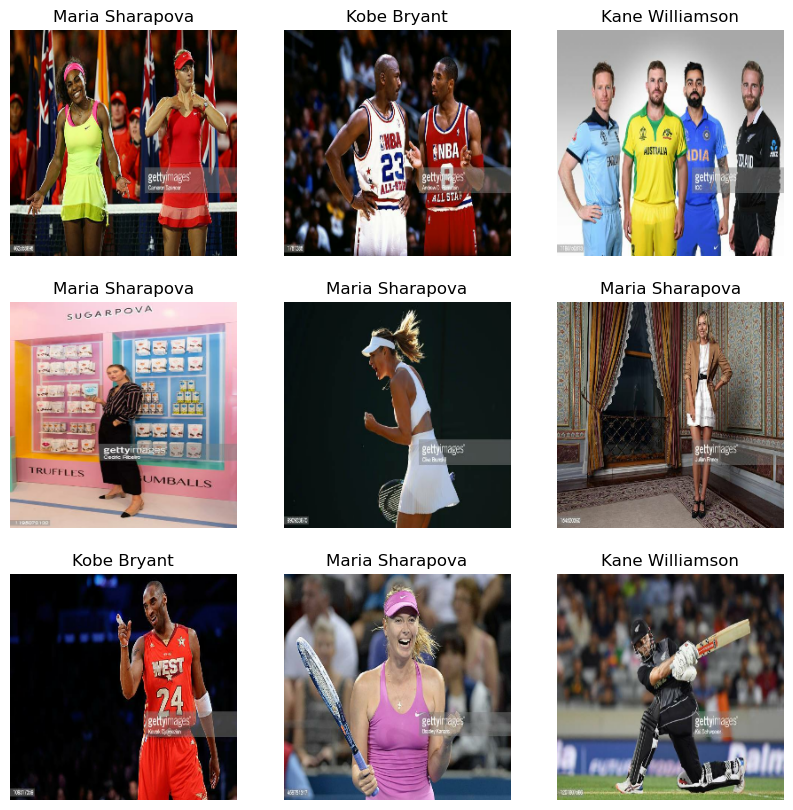

In [31]:
plot_images(data, 9)            

<a name="5"></a>
### <font color='red'> 5. Pre-processing </font>

### Train/Test Split

Let's divide our data into train, val and test sets.

In [36]:
def train_test_split(dataset, train_split=.8, val_split=.1):
    # First, shuffle the dataset
    dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    
    # len of the data
    data_size = len(dataset)

    # Define the split ratios (e.g., 80% train, 10% val, 10% test)
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    test_size = data_size - train_size - val_size

    # Split the dataset into train, validation, and test
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)

    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)
                   
    return train_dataset, val_dataset, test_dataset


In [37]:
train_data,val_data,test_data=train_test_split(data)

### Data Augmentation

In [43]:
# transformations
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

# apply (only to training!!!)
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y))

Let's see how this transformations looks like:

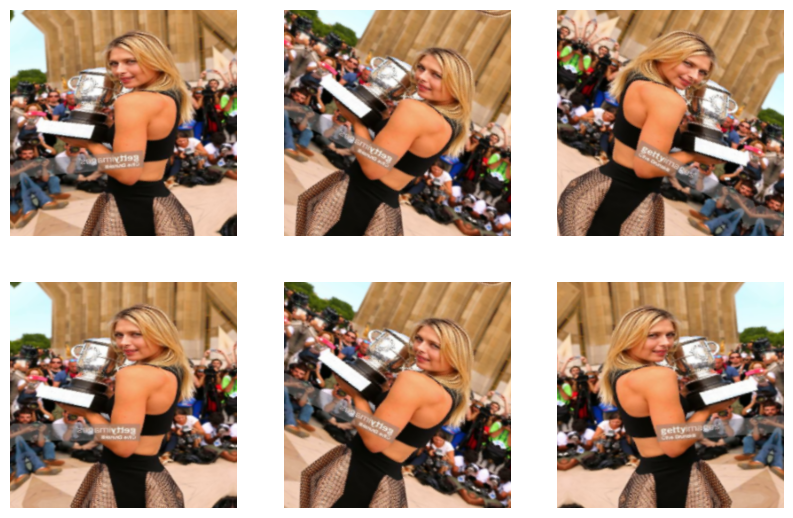

In [52]:
plot_augmented_images(train_data, 6)

### Configuration for performance

In [53]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<a name="5"></a>
### <font color='red'> 5. Models </font>

We are going to implememt the following model:


----> IMAGEN


In [136]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # escalado
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    # batch norm
    tf.keras.layers.BatchNormalization()
    
    
    # capas de conv seguidas de pooling y dropout
    
    for i in range(5): # 3
        x = layers.Conv2D(64, 3, strides=2, padding="same",activation="relu")(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.4)(x)
   
    
    # aplano    
    x = layers.Flatten()(x)
    
    # dense y dropout
    x = layers.Dense(64,activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # salida
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return tf.keras.Model(inputs, outputs)

model = make_model(input_shape=input_shape, num_classes=num_classes)


In [137]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                           

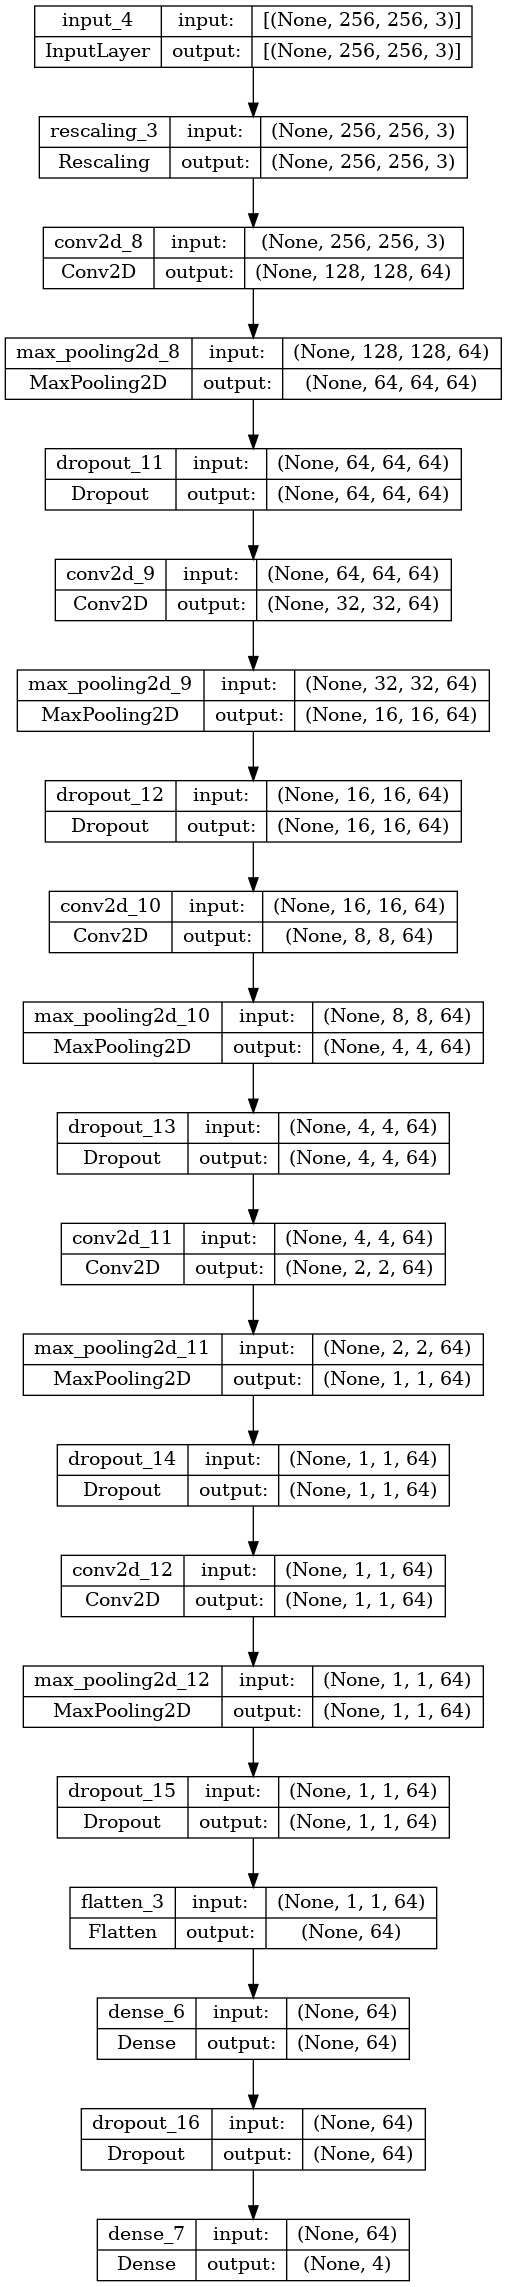

In [138]:
tf.keras.utils.plot_model(model, show_shapes=True)

Before we compile and fit the model, here are a couple of observations:

- Since we have more than two classes and the labels are one-hot encoded, the loss function will be Categorical Crossentropy.
- The argument from_logits will be set to False because the model's output consists of probability scores (i.e., the output of a softmax activation function).

In [139]:
# compile and fit
model.compile(optimizer="adam",
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras",save_best_only=True),
]

history=model.fit(
                  train_data, 
                  validation_data=val_data,
                  epochs=50, 
                  verbose=0,
                  batch_size=batch_size,
                  callbacks=callbacks)

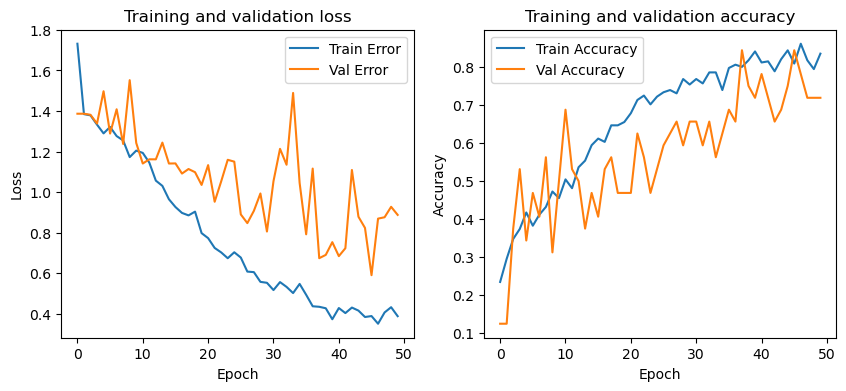

In [133]:
plot_history(history)

We see that, although the model is not very good, it seems to improve with each epoch, so training it for a longer time could yield better results.

Let's plot the confusion matrix:

1/1 [==============================] - 0s 118ms/step
[[10  0  5  2]
 [ 0 11  3  1]
 [ 2  2 13  0]
 [ 4  1  0 10]]


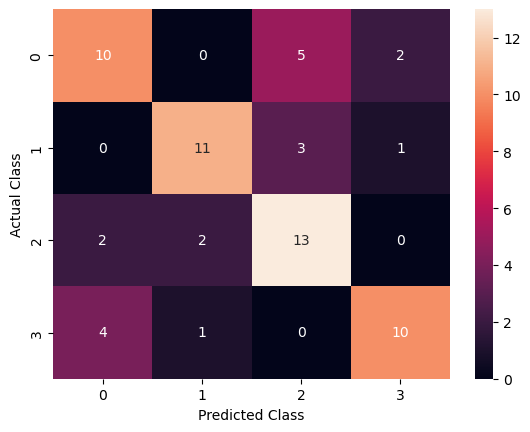

In [134]:
plot_confusion_matrix(model, test_data)

#### Rows and Columns:
- Each **row** represents the **true labels** (actual classes).
- Each **column** represents the **predicted labels** (predicted classes).

#### Key Observations:
1. **Class 0** (Row 0, Kane):
   - True Positives (correctly classified as Class 0): **13**
   - Misclassified as Class 2: **4**
   - Overall, Class 0 has high accuracy but struggles a bit with misclassification into Class 2.


2. **Class 1** (Row 1, Kobe):
   - True Positives: **12**
   - Misclassified as Class 2: **1**
   - Misclassified as Class 3: **2**
   - Class 1 shows good performance with minor misclassifications.


3. **Class 2** (Row 2, Maria):
   - True Positives: **12**
   - Misclassified as Class 0: **1**
   - Misclassified as Class 1: **4**
   - Class 2 struggles more with misclassifications compared to Classes 0 and 1.


4. **Class 3** (Row 3, Ronaldo):
   - True Positives: **8**
   - Misclassified as Class 0: **4**
   - Misclassified as Class 1: **1**
   - Misclassified as Class 2: **2**
   - Class 3 has the lowest accuracy among all classes, with substantial misclassifications into other classes, especially Class 0.

---

#### Overall Observations:
1. **Accuracy**:
   - Classes 0, 1, and 2 show relatively good accuracy, with the majority of predictions falling in the diagonal.
   - Class 3 has the weakest performance, as it has the lowest number of true positives and more misclassifications.


2. **Misclassifications**:
   - Most of the misclassifications involve neighboring or similar classes (e.g., Class 2 misclassified as Class 1 or 0, Class 3 misclassified as Class 0).
   - This may indicate overlapping features between these classes.


3. **Improvements Needed**:
   - **Class 3** requires attention as it has the poorest performance. You might consider collecting more data for Class 3 or adjusting the model to better distinguish its features.
   - The misclassification between Classes 0 and 2 could indicate similar features that the model struggles to separate. Feature engineering or fine-tuning the model may help here.

---

####  Summary:
- Overall, the model performs well on Classes 0, 1, and 2 but needs improvement for Class 3.
- Targeted strategies, such as data augmentation for underperforming classes or adjusting class weights, could improve the performance.


In [140]:
scores=model.evaluate(test_data)

2/2 [==============================] - 0s 92ms/step - loss: 1.1914 - accuracy: 0.5156


In [62]:
f"Performance is {round(scores[1]*100,2)}%, we must improve the model"

'Performance is 70.31%, we must improve the model'

<a name="6"></a>
### <font color='red'> 6. Hyperparameter Tuning </font>

Among the things we can adjust are:

- Optimization algorithm
- Learning rate
- Number of layers
- Number of units in each layer
- Kernel size
- Pool size
- Dropout rate
- Number of epochs
- Initialization method
- Network architecture

There are different methods to perform the tuning, including:

- GridSearch
- RandomSearch
- Bayesian Optimization

We can do it ourselves or use tools that assist with this task, such as:
<a href="https://keras.io/keras_tuner/">Keras Tuner</a>.

Here, we will use Keras Tuner and tune only a few hyperparameters over a limited number of epochs, as we do not have much computational power. <br>
We will tune:

- The optimizer
- The learning rate
- The dropout rate

We will use the Bayesian optimizer.

In [120]:
class MyHyperModel(keras_tuner.HyperModel) :
     def build(self, hp, classes=4,input_shape=input_shape):
            
            
        inputs = tf.keras.Input(shape=input_shape)

        # escalado
        x = layers.Rescaling(1.0 / 255)(inputs)

        # batch norm
        tf.keras.layers.BatchNormalization()


        # capas de conv seguidas de pooling y dropout

        for i in range(3):
            filters = hp.Choice('filters', [32, 64, 128]) 
            x = layers.Conv2D(filters, 3, strides=2, padding="same",activation="relu")(x)
            x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
            x = layers.Dropout(hp.Choice('rate1', [0.4, 0.6]))(x)


        # aplano    
        x = layers.Flatten()(x)

        # dense y dropout
        x = layers.Dense(64,activation='relu')(x)
        x = layers.Dropout(hp.Choice('rate2', [0.4, 0.6]))(x)

        # salida
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        
        # modelo
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        
        # compilación y demás
        model.compile(optimizer=hp.Choice('optim',['adam','adamax']),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics = ['accuracy'])
        
        # A way to optimize the learning rate while also trying different optimizers
        learning_rate = hp.Choice('lr', [ 0.03, 0.01, 0.003])
        K.set_value(model.optimizer.learning_rate, learning_rate)
        
        return model
        

In [121]:
tuner = keras_tuner.BayesianOptimization(
                        hypermodel=MyHyperModel(),
                        objective = "val_accuracy",
                        max_trials = 5, #max candidates to test
                        overwrite=True,
                        directory='search_dir',
                        project_name='sports_celebrities_dataset')

In [122]:
tuner.search(x=train_data, epochs=5,
             validation_data=val_data)

Trial 5 Complete [00h 00m 47s]
val_accuracy: 0.4375

Best val_accuracy So Far: 0.59375
Total elapsed time: 00h 02m 41s
INFO:tensorflow:Oracle triggered exit


In [123]:
tuner.results_summary(1)

Results summary
Results in search_dir/sports_celebrities_dataset
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
filters: 128
rate1: 0.6
rate2: 0.6
optim: adam
lr: 0.003
Score: 0.59375


In [124]:
# get the best values
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model2 = tuner.hypermodel.build(best_hps)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       147584    
                                                           

In [125]:
# train
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras",save_best_only=True),
]

history2 = model2.fit(
                  train_data, 
                  validation_data=val_data,
                  epochs=50, 
                  verbose=0,
                  batch_size=batch_size,                  
                  callbacks=callbacks)


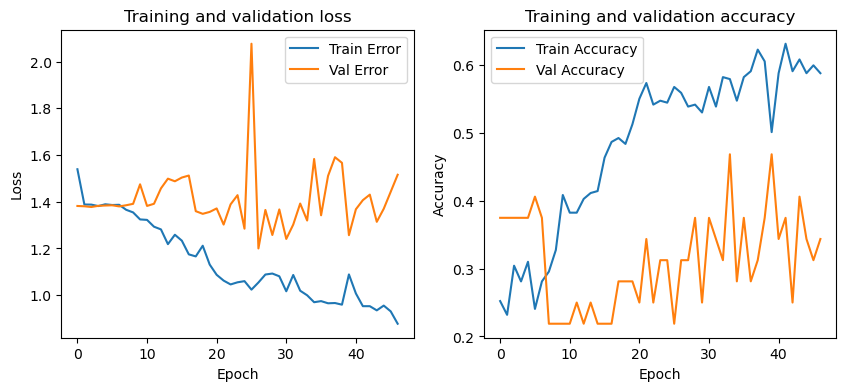

In [126]:
plot_history(history2)

1/1 [==============================] - 0s 187ms/step
[[ 4  6  7  0]
 [ 0 15  0  0]
 [ 0 15  2  0]
 [ 0  5  4  6]]


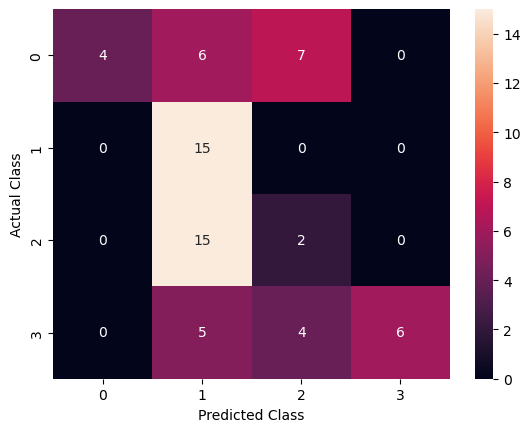

In [127]:
plot_confusion_matrix(model2,test_data)

In [128]:
scores2=model2.evaluate(test_data)

2/2 [==============================] - 0s 177ms/step - loss: 1.2769 - accuracy: 0.4219


EMPEORAMOS!!!!

<a name="7"></a>
### <font color='red'> 7. Predictions </font>

Let's see some predictions with our own images. First, we will write a function that makes the prediction. Remember that our model works with color images of 256x256.

In [ ]:
def predicts(model, img):
    """
    Make a prediction for a given image using the provided model.

    Args:
        model (tf.keras.Model): The trained TensorFlow model used for predictions.
        img (numpy.ndarray or tf.Tensor): The input image that needs to be classified. 
                                          The image should be a 256x256 array.

    Returns:
        predicted_class (str): The predicted class label based on the highest probability.
        confidence (float): The confidence of the prediction as a percentage.

    Example:
        predicted_class, confidence = predicts(model, img)

    Note:
        The input image will be resized to 256x256 pixels before making the prediction.
        The model is assumed to output class probabilities, and the class_names array 
        should be defined globally, mapping indices to class labels.
    """

    # Resize image to 256x256 pixels (if necessary)
    img = np.resize(img, (256, 256))  # Resize the image to match model input size

    # Convert image to array and expand dimensions for batch prediction
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert image to array
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Get model predictions
    predictions = model.predict(img_array)

    # Get the predicted class and confidence level (percentage)
    predicted_class = class_names[np.argmax(predictions[0])]  # Class with the highest probability
    confidence = round(100 * np.max(predictions[0]), 2)  # Confidence percentage

    # Return the predicted class and confidence level
    return predicted_class, confidence


Let's see some predictions on our test set:

1/1 [==============================] - 0s 18ms/step


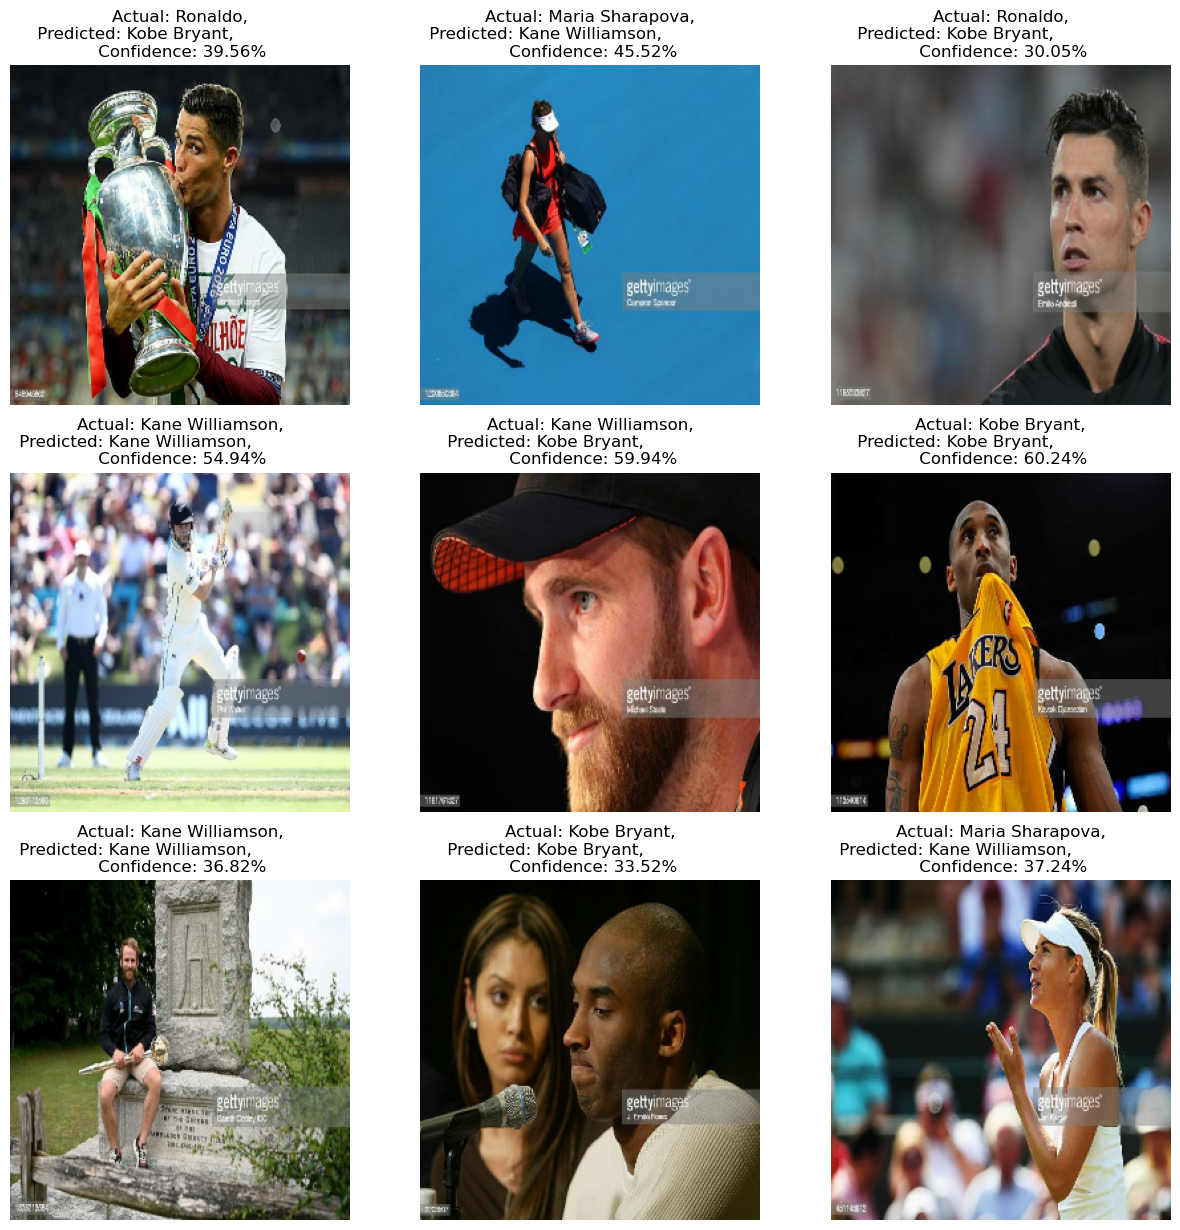

In [108]:
plt.figure(figsize=(15,15))
for images,labels in test_data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predicts(model2, images[i].numpy())
        actual_class=class_names[np.argmax(labels[i])] # labels es one-hot
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\
                  \n Confidence: {confidence}%")
        plt.axis("off")

Now we will make a prediction on one of our own images:

In [109]:
image_size = (256, 256)

img = keras.utils.load_img(
    "my_test_images/maria.png", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model2.predict(img_array)

indice_max = np.argmax(predictions[0])

prob_class = predictions[0][indice_max]
predicted_class=class_names[indice_max]


print(f"It predicts {predicted_class} with a confidence of {100*prob_class:.2f}%")

1/1 [==============================] - 0s 23ms/step
It predicts Maria Sharapova with a confidence of 33.17%


<a name="8"></a>
### <font color='red'> 8. Saving the model </font>

model.save() saves the entire model, which includes:

- Architecture: The model's structure (layers, configurations, etc.).
- Weights: The trained weights of the model.
- Optimizer: The state of the optimizer used during training, which allows you to resume training from where it left off.
- Metrics and Losses: The metrics and loss functions associated with the model during training.

After saving the model, we can reload it and resume training or make predictions without needing to redefine the architecture or recompile it.

In [110]:
model.save('model2.keras')

To use it:

In [112]:
model = keras.models.load_model('model2.keras')